In [2]:
import pandas as pd

In [3]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

# brands_cl.csv
url = "https://drive.google.com/file/d/1XGyabaa4mAkjixMk3XPgx_14OoSse3rs/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
brands = pd.read_csv(path)

In [4]:
orders_df = orders_cl.copy()
orderlines_df = orderlines_cl.copy()
products_df = products_cl.copy()
brands_df = brands.copy()

### Exclude unwanted orders

In [5]:
# your code here
# 1. Filter down to just sales
state_mask = orders_df['state'].isin(['Cancelled', 'Shopping Basket'])
orders_completed = orders_df.loc[~state_mask].copy()

# 2. Filter orderlines just those in the orders data frame
# 2.1 identify orders in orders df
orders_in_o_df = orders_completed['order_id']
# 2.2 filter orderlines to just those
orderlines_connected = orderlines_df.loc[orderlines_df['id_order'].isin(orders_in_o_df)].copy()

#3. Filter orders down to just those in the orderlines data frame
# 2.1 identify orders in orderlines df
orders_in_ol_df = orderlines_df['id_order']
# 2.2 filter orders to just those
orders_connected = orders_completed.loc[orders_completed['order_id'].isin(orders_in_ol_df)]

### Exclude orders with unknown products

In [9]:
# your code here
# 1. Identify corrupted orderlines
existing_products = products_cl['sku']
corrupted_filter = ~(orderlines_connected['sku'].isin(existing_products))

# 2. Identify orders with corrupted orderlines (they are corrupted)
corrupted_orders = orderlines_connected.loc[corrupted_filter, 'id_order']
clean_orders = orders_connected.loc[~(orders_connected['order_id'].isin(corrupted_orders))]

# 3. Identify other orderlines in corrupted orders
clean_orderlines = orderlines_connected.loc[~(orderlines_connected['id_order'].isin(corrupted_orders))]

### Explore revenue

##### Create `unit_price_total` column in `orderlines`

In [11]:
clean_orderlines.loc[:, 'unit_price_total'] = (clean_orderlines['unit_price']
                                               * clean_orderlines['product_quantity'])

C:\Users\kosta\AppData\Local\Temp\ipykernel_10760\816583924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_orderlines.loc[:, 'unit_price_total'] = (clean_orderlines['unit_price']


##### Merge the total it with `orders`

in this way we can compare the total paid, with the total cost of the order and spot extra costs or discounts

In [12]:
price_totals = (
    clean_orderlines
    .groupby('id_order')
    .agg({'unit_price_total':'sum'})
)
orders_info = clean_orders.merge(price_totals,
                                 left_on='order_id',
                                 right_on='id_order')
orders_info

,order_id,created_date,total_paid,state,unit_price_total
0,241423,2017-11-06 13:10:02,136.15,Completed,129.16
1,242832,2017-12-31 17:40:03,15.76,Completed,10.77
2,243330,2017-02-16 10:59:38,84.98,Completed,77.99
3,245275,2017-06-28 11:35:37,149.00,Completed,149.00
4,245595,2017-01-21 12:52:47,112.97,Completed,105.98
...,...,...,...,...,...
77190,527392,2018-03-14 13:55:11,34.99,Pending,34.99
77191,527394,2018-03-14 13:55:15,161.00,Place Order,161.00
77192,527396,2018-03-14 13:55:44,141.58,Place Order,141.58
77193,527397,2018-03-14 13:56:38,42.99,Place Order,42.99


##### What is the `average` difference between `total_paid` and `unit_price_total`?

In [13]:
orders_info.loc[:, 'difference'] = (orders_info['total_paid']
                                    - orders_info['unit_price_total'])
orders_info['difference'].describe()

count    77195.000000
mean         3.374529
std         19.354553
min       -165.000000
25%          0.000000
50%          3.990000
75%          4.990000
max       3984.990000
Name: difference, dtype: float64

##### What is the distribution of these differences?

In [14]:
q1 = orders_info['difference'].quantile(0.25)
q3 = orders_info['difference'].quantile(0.75)

iqr = q3 - q1

upper_bound = q3 + (1.5 * iqr)
lower_bound = q1 - (1.5 * iqr)
print(upper_bound, lower_bound)

12.475000000000023 -7.485000000000014


<Axes: >

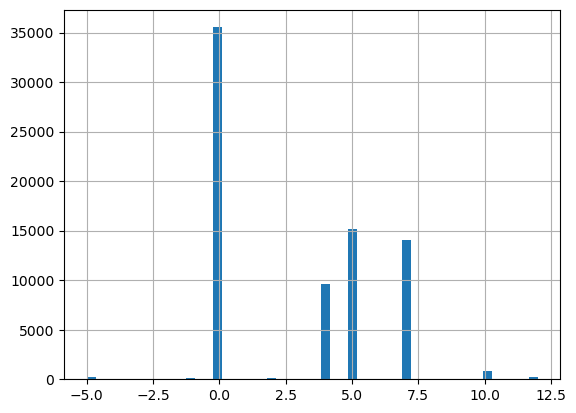

In [15]:
(
    orders_info
    .loc[orders_info['difference'].between(lower_bound, upper_bound)]
    ['difference'].hist(bins=50)
)